# SPACEc:Distance permutation analysis

## Set up environment

In [1]:
import os
import time
import sys
import anndata as ad
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/' # where the data is stored
code_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/pipeline_test_112023/src' # current where the code is stored, this will be replaced by pip install soon
output_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/output_112023/' #where you want to store the output

if not os.path.exists(output_dir): # check if output path exist - if not generate the path
    os.makedirs(output_dir)
    
sys.path.append(code_dir) 

from helperfunctions_hf import * # Helper functions - used by other functions to execute steps like table formatting etc. KEY: hf
from preprocessing_pp import * # Preprocessing functions - to normalize and prepare data for further analysis KEY: pp
from tools_tl import * # tools - perform calculation on the data KEY: tl
from plot_pl import * # plotting functions - used to visualize results KEY: pl

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
# Load data
adata = sc.read(output_dir + "adata_nn_demo_annotated_cn.h5ad")
adata

AnnData object with n_obs × n_vars = 48776 × 58
    obs: 'DAPI', 'x', 'y', 'area', 'region_num', 'region', 'unique_region', 'condition', 'leiden_0.4', 'leiden_0.4_subcluster_0', 'leiden_0.4_subcluster_3', 'leiden_0.4_subcluster_4', 'celltype', 'leiden_0.4_subcluster_2', 'leiden_0.4_subcluster_11', 'leiden_0.4_subcluster_0sub', 'celltype_fine', 'CN_k20_n6', 'CN_k20_n6_annot'
    uns: 'Centroid_k20_n6', 'celltype_colors', 'celltype_fine_colors', 'dendrogram_leiden_0.4', 'dendrogram_leiden_0.4_subcluster_4', 'leiden', 'leiden_0.4_colors', 'leiden_0.4_subcluster_0sub_colors', 'leiden_0.4_subcluster_4_colors', 'neighbors', 'umap', 'unique_region_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

## 5.1 Identify potential interactions

In [3]:
distance_pvals = tl_identify_interactions_ad(adata = adata , 
                                                id = "index", 
                                                x_pos = "x", 
                                                y_pos = "y", 
                                                cell_type = "celltype", 
                                                region = "unique_region",
                                                num_iterations=100,
                                                num_cores=10, 
                                                min_observed = 10,
                                                comparison = 'condition')
distance_pvals.head()

Computing for observed distances between cell types!
This function expects integer values for xy coordinates.
x and y will be changed to integer. Please check the generated output!
Save triangulation distances output to anndata.uns triDist
Permuting data labels to obtain the randomly distributed distances!
this step can take awhile
Save iterative triangulation distance output to anndata.uns triDist


,celltype1,celltype2,condition,expected,expected_mean,keep_x,observed,observed_mean,keep_y,pvalue,logfold_group,interaction
0,B,B,tonsil,"[17.60682948526482, 17.350859579710974, 18.204...",17.855596,True,"[20.545213045154394, 12.640710916424354, 26.44...",17.370644,True,1.390194e-05,-0.039725,B --> B
1,B,B,tonsillitis,"[17.15736313749573, 18.1458220344794, 16.76025...",17.317646,True,"[18.841045317879118, 12.407317850634978, 13.22...",16.438037,True,1.737638e-10,-0.075205,B --> B
2,B,CD4T,tonsil,"[18.28899800925287, 17.806343952288643, 17.736...",17.901684,True,"[20.06283455121945, 20.591260281974, 14.035668...",16.975155,True,5.090535e-07,-0.076671,B --> CD4T
3,B,CD4T,tonsillitis,"[17.315019390683307, 17.640116887710665, 16.79...",17.351514,True,"[11.40175425099138, 10.113096545225039, 12.083...",16.292903,True,4.207976e-10,-0.090818,B --> CD4T
4,B,CD8T,tonsil,"[17.813254512050268, 17.814424036584164, 17.73...",17.956441,True,"[7.810249675906654, 13.601470508735444, 11.180...",16.784066,True,3.203655e-07,-0.097409,B --> CD8T


In [4]:
# Identify significant cell-cell interactions
# dist_table_filt is a simplified table used for plotting
# dist_data_filt contains the filtered raw data with more information about the pairs
dist_table_filt, dist_data_filt = tl_filter_interactions(distance_pvals = distance_pvals,
                                            pvalue = 0.05,
                                            logfold_group_abs = 0.1)

print(dist_table_filt.shape)
dist_data_filt.head()

(33, 2)


,celltype1,celltype2,condition,expected,expected_mean,keep_x,observed,observed_mean,keep_y,pvalue,logfold_group,interaction,logfold_group_abs,pairs
2,B,CD4T,tonsil,"[18.28899800925287, 17.806343952288643, 17.736...",17.901684,True,"[20.06283455121945, 20.591260281974, 14.035668...",16.975155,True,5.090535e-07,-0.076671,B --> CD4T,0.076671,B_CD4T
3,B,CD4T,tonsillitis,"[17.315019390683307, 17.640116887710665, 16.79...",17.351514,True,"[11.40175425099138, 10.113096545225039, 12.083...",16.292903,True,4.207976e-10,-0.090818,B --> CD4T,0.090818,B_CD4T
4,B,CD8T,tonsil,"[17.813254512050268, 17.814424036584164, 17.73...",17.956441,True,"[7.810249675906654, 13.601470508735444, 11.180...",16.784066,True,3.203655e-07,-0.097409,B --> CD8T,0.097409,B_CD8T
5,B,CD8T,tonsillitis,"[16.79608212561209, 16.969287382208083, 16.831...",17.393808,True,"[16.401219466856727, 13.038404810405298, 17.20...",16.003530,True,6.421014e-10,-0.120184,B --> CD8T,0.120184,B_CD8T
6,B,DC,tonsil,"[17.39476967555677, 17.561005581569972, 17.619...",17.841615,True,"[14.0, 22.360679774997898, 15.297058540778355,...",17.583019,True,3.386770e-03,-0.021063,B --> DC,0.021063,B_DC


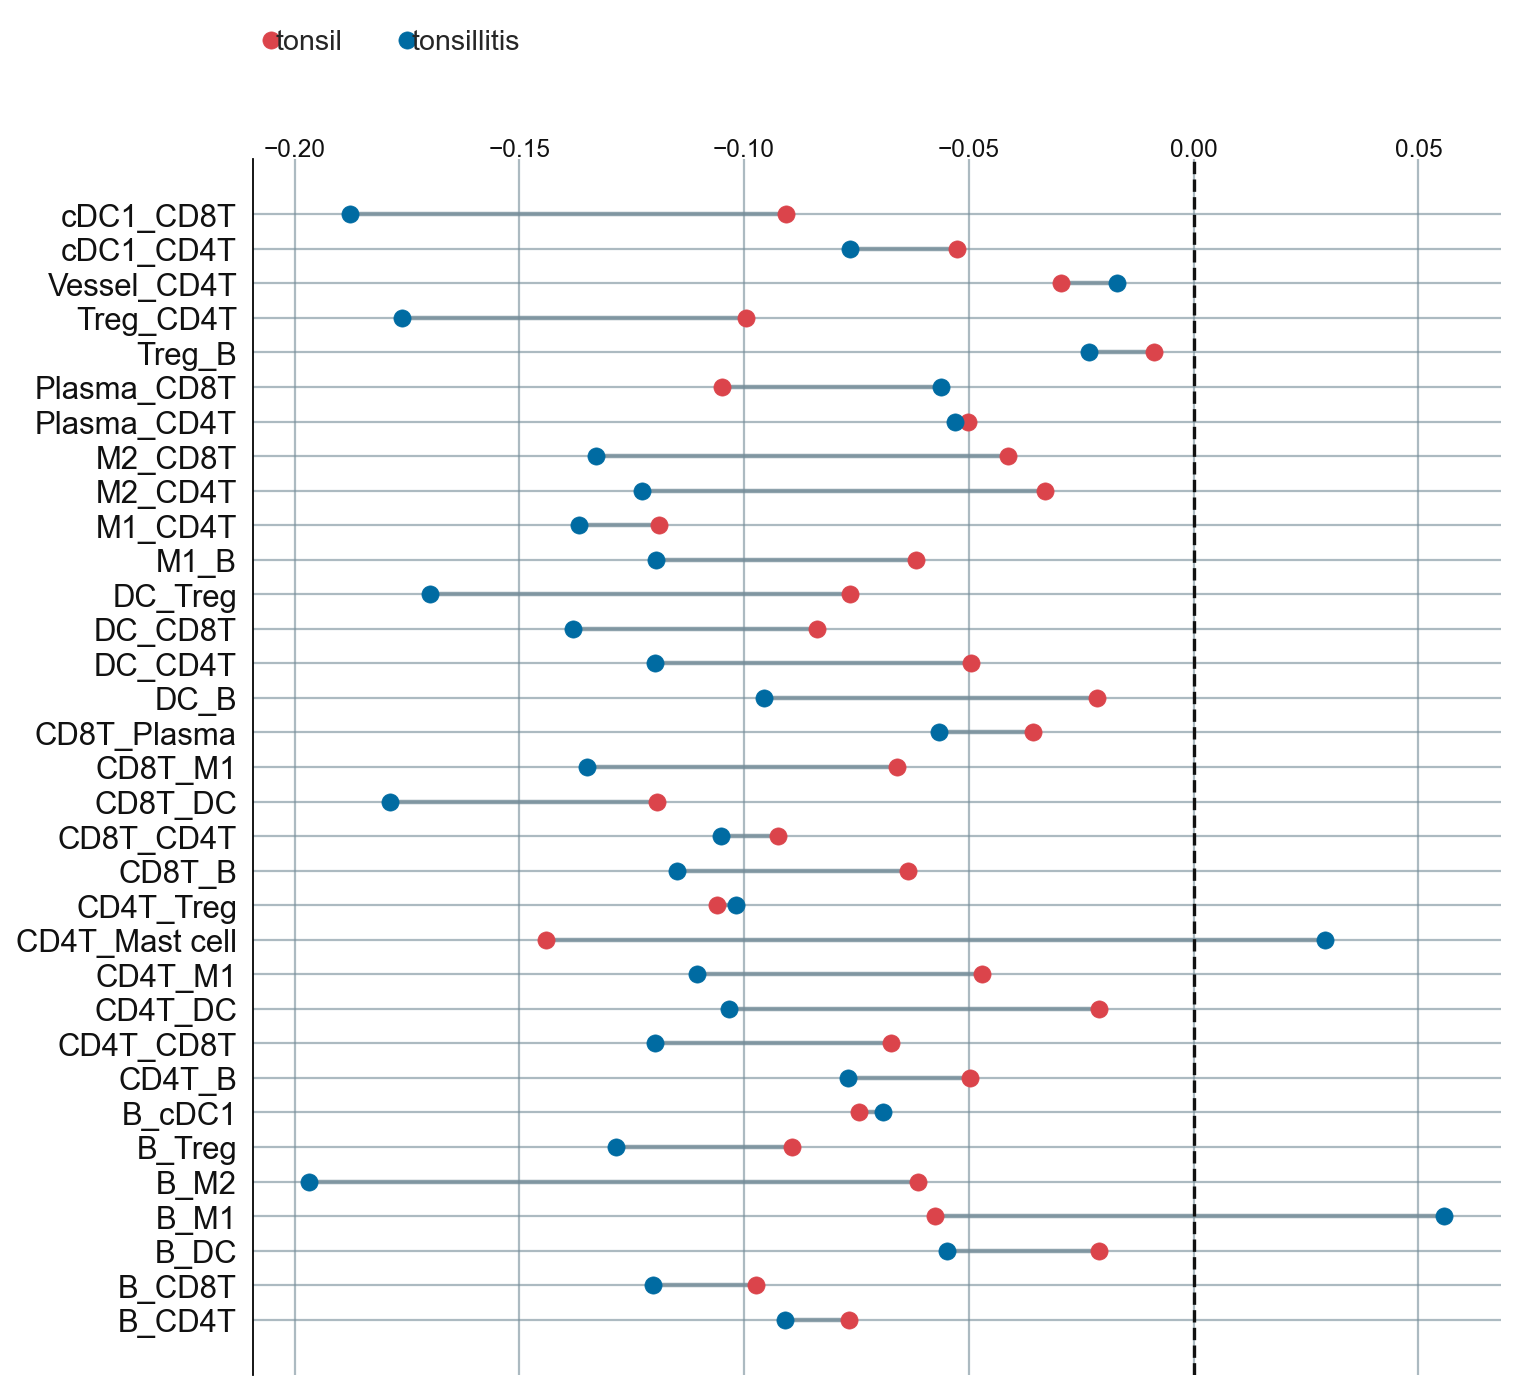

In [5]:
pl_dumbbell(data = dist_table_filt, figsize=(10,10), colors = ['#DB444B', '#006BA2'])